In [1]:
import os, sys, re, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
from tensorflow import keras
print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.2.0
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [18]:
ORIGIN_DATA_DIR = os.getcwd()+'/all_fearures/BX-CSV-Dump/'
FILTERED_DATA_DIR = os.getcwd()+'/tmp/'
class DataLoad:
    def __init__(self):
        '''
        books_with_blurbs.csv cloumns: ISBN,text,Author,Year,Publisher,Blurb
        BX-Book-Ratings.csv cloumns: User-ID,ISBN,Book-Rating
        BX-Books.csv cloumns: ISBN,Book-text,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
        BX-Users.csv cloumns: User-ID,Location,Age
        '''
        self.BX_Users = self.load_origin('BX-Users')
        self.BX_Book_Ratings = self.load_origin('BX-Book-Ratings')
        self.books_with_blurbs = self.load_origin('books_with_blurbs', ',')
        #合并三个表
        self.features = self.get_features()
        self.labels = self.features.pop('Book-Rating')
    def load_origin(self, 
        filename: "根据文件名获取源文件，获取正确得columns、values等值", 
        sep: "因为源文件的分隔方式sep不同，所以通过传参改编分隔方式"="\";\"", 
        )->pd.DataFrame:
        '''
        获取原始数据，第一遍获取后将用pickle保存到本地，方便日后调用
        '''
        try:
            # 从缓存的文件夹FILTERED_DATA_DIR获取基本被过滤后的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+filename+'.p', mode='rb'))
            return pickled_data
        except FileNotFoundError:
            # 如果缓存的文件不存在或者没有，则在源目录ORIGIN_DATA_DIR获取
            all_fearures = pd.read_csv(ORIGIN_DATA_DIR+filename+'.csv', engine='python',sep=sep, encoding='utf-8')
            # \";\"  初始过滤的文件
            # ,      初始不需要过滤的文件
            data_dict = {"\";\"":self.filtrator(all_fearures), ',':all_fearures}
            # 因为没获得处理后的文件，所以我们在获取源文件后可以保存一下处理后的文件
            pickle.dump((data_dict[sep]), open(FILTERED_DATA_DIR+filename+'.p', 'wb'))
            return data_dict[sep]
        except UnicodeDecodeError as e:
            ''' 测试时经常会出现编码错误，如果尝试更换编码方式无效，可以将编码错误的部分位置重新复制粘贴就可以了，这里我们都默认UTF-8'''
            print('UnicodeDecodeError:',e)
        except pd.errors.ParserError as e:
            print("connect error|pandas Error: %s" % e)

    def filtrator(self, 
        f_data: "输入需要进行初步filter的数据"
        )->pd.DataFrame:
        '''
        源文件中的columns和各个值得第一列的第一个字符和最后一列的最后一个字符都带有双引号‘"’,需要将其filter,Location字段当用户Age为null的时候，末尾会有\";NULL字符串 ，直接用切片调整
        '''
        Nonetype_age = 0
        f_data = f_data.rename(columns={f_data.columns[0]:f_data.columns[0][1:], f_data.columns[-1]:f_data.columns[-1][:-1]})
        f_data[f_data.columns[0]] = f_data[f_data.columns[0]].map(lambda v:v[1:] if v!=None else Nonetype_age)
        f_data[f_data.columns[-1]] = f_data[f_data.columns[-1]].map(lambda v:v[:-1] if v!=None else Nonetype_age)
        try:
            f_data = f_data[f_data['Location'].notnull()][f_data[f_data['Location'].notnull()]['Location'].str.contains('\";NULL')]
            f_data['Location'] = f_data['Location'].map(lambda location:location[:-6])
        except:
            pass
        return f_data

    def get_features(self):
        '''
        获取整个数据集的所有features，并对每个文本字段作xxxxx
        User-ID
        Location
        ISBN
        Book-Rating
        Title
        Author
        Year
        Publisher
        Blurb
        '''
        try:
            # 从缓存的文件夹FILTERED_DATA_DIR获取features的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+'features.p', mode='rb'))
            return pickled_data
        except FileNotFoundError:
            # 将所有的数据组成features大表
            all_fearures = pd.merge(pd.merge(self.BX_Users, self.BX_Book_Ratings), self.books_with_blurbs)
            # 因为没获得处理后的文件，所以我们在获取源文件后可以保存一下处理后的文件
            all_fearures.pop('Age')
            all_fearures['Title'] = self.feature2int(all_fearures['Title'], 'text')
            all_fearures['Blurb'] = self.feature2int(all_fearures['Blurb'], 'text')
            all_fearures['ISBN'] = self.feature2int(all_fearures['ISBN'], 'word')
            all_fearures['Author'] = self.feature2int(all_fearures['Author'], 'word')
            all_fearures['Publisher'] = self.feature2int(all_fearures['Publisher'], 'word')
            all_fearures['Year'] = self.feature2int(all_fearures['Year'], 'word')
            all_fearures['User-ID'] = self.feature2int(all_fearures['User-ID'], 'word')
            all_fearures['Location'] = self.feature2int(all_fearures['Location'], 'list')
            all_fearures['Book-Rating'] = all_fearures['Book-Rating'].astype('float32')
#             pickle.dump(all_fearures, open(FILTERED_DATA_DIR+'features.p', 'wb'))
            return all_fearures

    def feature2int(self, 
        feature:'特征值',
        feature_type:'text/word/list'):
        '''
        将文本字段比如title、blurb只取英文单词，并用空格为分隔符，做成一个带index值的集合，并用index值表示各个单词，作为文本得表示
        '''
        pattern = re.compile(r'[^a-zA-Z]')
        filtered_map = {val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) }
        letter_filter = lambda feature:feature.map({val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) })
        text_words = set()
        filtered_feature = letter_filter(feature)
        for val in filtered_feature.str.split():
            text_words.update(val)
        text2int = {val:ii for ii, val in enumerate(text_words)}
        text_map = {val:[text2int[row] for row in filtered_map[val].split()][:200] for ii,val in enumerate(set(feature))}
        
        word_map = {val:ii for ii,val in enumerate(set(feature))}
        try:
            cities = set()
            for val in feature.str.split(','):
                cities.update(val)
            city_index = {val:ii for ii, val in enumerate(cities)}
            list_map = {val:[city_index[row] for row in val.split(',')][:3] for ii,val in enumerate(set(feature))}
        except AttributeError :
            list_map = {}

        feature_dict = {
            'text':feature.map(text_map),
            'word':feature.map(word_map),
            'list':feature.map(list_map),
            }
        return feature_dict[feature_type]

    def __del__(self):
        pass

origin_DATA = DataLoad()

In [19]:
origin_DATA.features

,User-ID,Location,ISBN,Title,Author,Year,Publisher,Blurb
0,940,"[1401, 3424, 2903]",16778,"[9824, 23412, 22339, 1487, 1487, 1487, 1487, 1...",11446,63,1887,"[43238, 127172, 28249, 110191, 61356, 126135, ..."
1,940,"[1401, 3424, 2903]",24957,"[16299, 21557, 19070, 21476, 10543, 22335, 189...",7382,71,1103,"[57585, 125932, 47159, 113373, 57374, 28249, 6..."
2,5414,"[5603, 3840, 2903]",24957,"[16299, 21557, 19070, 21476, 10543, 22335, 189...",7382,71,1103,"[57585, 125932, 47159, 113373, 57374, 28249, 6..."
3,15427,"[6321, 1194, 5296]",24957,"[16299, 21557, 19070, 21476, 10543, 22335, 189...",7382,71,1103,"[57585, 125932, 47159, 113373, 57374, 28249, 6..."
4,7287,"[3405, 2889, 5296]",24957,"[16299, 21557, 19070, 21476, 10543, 22335, 189...",7382,71,1103,"[57585, 125932, 47159, 113373, 57374, 28249, 6..."
...,...,...,...,...,...,...,...,...
172097,1491,"[370, 968, 5296]",32297,"[5119, 19964, 800, 10977, 8008, 8931, 10977, 8...",13128,70,2026,"[93007, 21371, 53000, 28249, 48632, 123469, 39..."
172098,7079,"[3244, 4575, 5296]",30438,"[20477, 19074, 5739, 14968, 800, 7132, 7507, 8...",11098,75,145,"[67310, 52923, 29464, 19034, 20042, 53000, 396..."
172099,7079,"[3244, 4575, 5296]",33460,"[22507, 12423, 1487, 1487, 1487, 1487, 1487, 1...",3385,75,2480,"[75823, 21876, 89381, 53000, 8113, 85559, 1528..."
172100,7079,"[3244, 4575, 5296]",16729,"[18460, 17985, 19551, 6077, 1487, 1487, 1487, ...",13280,76,2461,"[42242, 6474, 30684, 2161, 15285, 68522, 36348..."


In [20]:
origin_DATA.labels

0         0.0
1         0.0
2         0.0
3         6.0
4         0.0
         ... 
172097    8.0
172098    0.0
172099    0.0
172100    6.0
172101    7.0
Name: Book-Rating, Length: 172102, dtype: float32

In [24]:
origin_DATA.features.dtypes

User-ID       int64
Location     object
ISBN          int64
Title        object
Author        int64
Year          int64
Publisher     int64
Blurb        object
dtype: object

In [25]:
def distribution_analysis(data):
    sections = data.value_counts()
    '''
    绘制折线图，表示数据的频率分布
    '''
    sections = sections.sort_index()
    print('源数据频率分布\n', sections)
    return sections

源数据频率分布
 0.0     94342
1.0       361
2.0       534
3.0      1173
4.0      1669
5.0     10423
6.0      6983
7.0     14504
8.0     19309
9.0     11408
10.0    11396
Name: Book-Rating, dtype: int64


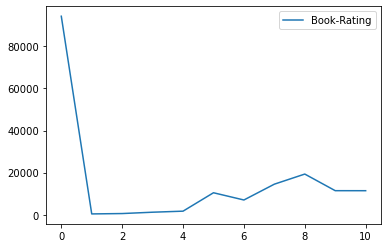

In [26]:
distribution_analysis(origin_DATA.labels).plot(y='Book-Rating', legend='Book-Rating')

源数据频率分布
 0         1
1         1
2         1
3        13
4        18
         ..
28831     1
28832     2
28833     1
28834     1
28835     1
Name: User-ID, Length: 28836, dtype: int64


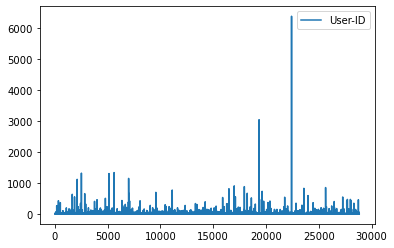

In [27]:
distribution_analysis(origin_DATA.features['User-ID']).plot(legend='User-ID')

源数据频率分布
 0     1654
1        8
2        1
3        3
4        3
      ... 
76    3321
77      10
78      10
79       1
80       5
Name: Year, Length: 81, dtype: int64


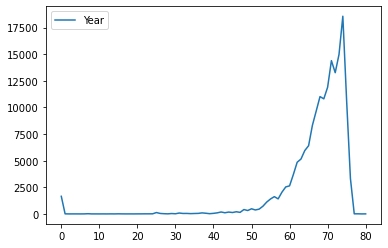

In [28]:
distribution_analysis(origin_DATA.features['Year']).plot(legend='Book-year')